# import

In [1]:
!which python
import struct 
struct.calcsize("P")*8
# pd.set_option('display.max_rows', sub_pressure_df.shape[0]+1)

/c/Users/junec/AppData/Local/Programs/Python/Python38/python


32

In [2]:
# !pip list
# !pip install openpyxl
#!pip install Shapely
#!pip install descartes
#!pip install hampel

In [3]:
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import rcParams
from operator import itemgetter
from typing import Callable, Dict, List, Set, Tuple
from scipy.optimize import curve_fit
import csv
import json
from collections import defaultdict
from scipy.signal import savgol_filter
import math 
import warnings
warnings.simplefilter('ignore', np.RankWarning)
from pprint import pprint
import os

In [4]:
import sys
sys.path.insert(1, 'methods')
sys.path.insert(1, 'util')
from util import SelectRows,calculate_derivative,pointInterval_to_pressure,point_dt_to_pressure,print_tuning_parameters,timeInterval_to_sub_df, save_json, load_json
from baseline_method import detect_breakpoints_startPoint, detect_breakpoints, detect_breakpoints_2, detect_breakpoints_3,detect_breakpoints_4,detect_breakpoints_startPoint2
from plot import PlotNSave
from plot2 import PlotNSave, plot_histogram
from data_load_N_preprocess import LoadNPreprocessData
from base_classes import CurveParametersCalc
from patternRecognition_method import PatternRecognitionMethod
from tangent_method import TangentMethod
# from advanced_method import detect_max_FOD
from derivative_method import DerivativeMethod
from store_transients import StoreTransients
# from patternRecognition_method_N_tangent_method import PatternRecognition


# load data and process

## denoised data

In [5]:
#experiment setup
print("load & denoise real field data===========================")
ground_truth_temp=[2249,  2467,  2805,[2875, 2876],3100,3561,3994,[4228, 4232],4753,4895, 5297,5436,5985,[6543, 6547], 7249,[7544, 7545],7946,[8362, 8364],9025,[9607, 9608],10149,10216, 10528,[10801, 10804],11340,  11479,12363,[13039, 13040],13868, 14086,14774,15341,16098,16619,[17589, 17590],18435,19643,19764,20021,20349,20701,21030,21974,22186,22710,23220,24215,24685,25717,26006,26656, 26759,27023,[27316,27327],27773,[27966,27970],28322,28497,28832,29115]
colum_names_denoised   ={"pressure":{"time":"Elapsed time(hr)",
                             "measure":"Pressure(psia)",
                             "first_order_derivative":"first_order_derivative",
                             "second_order_derivative":"second_order_derivative"},
                "rate":{"time":"Elapsed time(hr)",
                        "measure":"Liquid rate(STB/D)"}}
data_inOneRow_denoised=1200
pressure_filePath="../data_input/EAGE_Shchipanov_2017/Pressure.txt"
rate_filePath="../data_input/EAGE_Shchipanov_2017/Rate.txt"
ground_truth=[]
for point in ground_truth_temp: 
    if "list" in str(type(point)):
        ground_truth.append(math.ceil(sum(point)/len(point)))
    else:
        ground_truth.append(point)
                     

processed_data_denoised=LoadNPreprocessData(pressure_filePath=pressure_filePath, 
                 rate_filePath=rate_filePath, 
                 colum_names=colum_names_denoised, 
                 use_SG_smoothing=True)
pressure_df_denoised=processed_data_denoised.pressure_df
rate_df_denoised=processed_data_denoised.rate_df

pressure_df=pressure_df_denoised
pressure_measure_denoised=list(pressure_df[colum_names_denoised["pressure"]["measure"]])
# print("len(pressure_measure_denoised)",len(pressure_measure_denoised))
pressure_time_denoised=list(pressure_df[colum_names_denoised["pressure"]["time"]])
second_derivatives=list(pressure_df[colum_names_denoised["pressure"]["second_order_derivative"]])
# ground truth adapted for denoise data
ground_truth_denoised=[2248, 2467, 2804, 2884, 3095, 3560, 3987, 4246, 4750, 4899, 5297, 5436, 5983, 6543, 7249, 7545, 7946, 8361, 9024, 9619, 10149, 10224, 10527, 10800, 11340,11490, 12362, 13040, 13867, 14089, 14766, 15348, 16097, 16619, 17589, 18434, 19642, 19777, 20014, 20358, 20700, 21025, 21974, 22183, 22709, 23219, 24215, 24683, 25698, 26011, 26656, 26753, 27022, 27315, 27760, 27969, 28322, 28494, 28831, 29115]
print("len(ground_truth_denoised)",len(ground_truth_denoised))
ground_truth_badQuality=[9024,10800,2467,10224,21025,26753]
for item in ground_truth_badQuality:
    ground_truth_denoised.remove(item)

print("after remove uncorrect ground truth")
print("len(ground_truth_denoised)",len(ground_truth_denoised))

load & denoise real field data===========================
---load data from 'txt' or 'xlsx' files...
check the time type
---denoising data using S-G smoothing...
---The first & second order derivative has been calculated and appended to pressure dataframe
len(ground_truth_denoised) 60
after remove uncorrect ground truth
len(ground_truth_denoised) 54


In [6]:
pressure_measure=pressure_measure_denoised
pressure_time=pressure_time_denoised
pressure_df=pressure_df_denoised
# pressure_measure=pressure_measure_denoised[0:3500]
# pressure_time=pressure_time_denoised[0:3500]
# pressure_df=pressure_df_denoised[0:3500]
ground_truth=ground_truth_denoised
rate_df=rate_df_denoised
colum_names=colum_names_denoised
data_inOneRow=data_inOneRow_denoised

In [7]:
display(pressure_df.describe())

,Elapsed time(hr),Pressure(psia),first_order_derivative,second_order_derivative
count,29813.000000,29813.000000,29813.000000,29813.000000
mean,1949.504754,5858.252763,30.980488,-3316.399705
std,1071.285888,1201.608375,217.076860,26067.263416
min,0.000000,2989.186167,-1177.363679,-267661.267543
25%,1223.614626,4920.227064,-26.315082,-150.940811
50%,2055.749995,5958.685278,6.577672,0.048895
75%,2691.845828,6884.300893,50.575874,129.782625
max,4070.949737,7942.372157,1442.449150,199644.890976


In [8]:
display(rate_df.describe())

,Elapsed time(hr),Liquid rate(STB/D)
count,10191.000000,10191.000000
mean,2210.383315,-16880.702745
std,1121.860526,4591.205914
min,0.433384,-22568.277381
25%,1345.039547,-19746.868884
50%,2248.487512,-18758.998204
75%,3074.228818,-15911.221687
max,4075.570423,1.166046


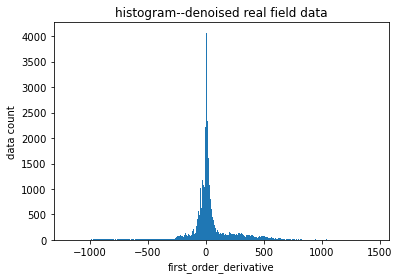

In [10]:
#plot histogram
data=pressure_df["first_order_derivative"]
xlabel="first_order_derivative"
ylabel="data count"
title='histogram--denoised real field data'
plot_histogram(data, xlabel, ylabel,title)